# Why Descend under the Spectral Norm?

In [ ]:
import re

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rcParams["font.family"] = "monospace"

In [ ]:
# Training parameters
NUM_DEVICES = 8
BATCH_PER_DEVICE = 1
SEQ_LEN = 64 * 1024
N_EMBD = 768
N_HEAD = 6
N_LAYERS = 12

NUM_ITERATIONS = 1825
VAL_LOSS_EVERY = 125

In [ ]:
IMAGES_SAVE_PATH = "."
FRO_NORM_PATTERN = r"fro_norm = ([0-9.]+)"
SPEC_NORM_PATTERN = r"spectral_norm = ([0-9.]+)"
WEIGHT_NAME_PATTERN = r"transformer\.h\.([0-9]+)\.attn\.(c_q|c_k)\.weight"

## Prepare data

### Load and preprocess data

In [ ]:
filenames = [
    "14091bb9-d75e-482e-a5f9-f32ef1c17ae6.txt",
    "22a49b2a-84c6-4522-a68b-02f3ae7107dc.txt",
]

files = [open(filename, "r").readlines() for filename in filenames]

In [ ]:
# layers: list[list[int]] = [[] for _ in range(len(files))]
# weight_names: list[list[str]] = [[] for _ in range(len(files))]
matrix_norms: list[list[list[float]]] = [[] for _ in range(len(files))]
for idx, file in enumerate(files):
    for line in file:
        if "module._orig_mod." not in line:
            continue
        layer_weight = re.search(WEIGHT_NAME_PATTERN, line)
        fro_norm = re.search(FRO_NORM_PATTERN, line)
        spec_norm = re.search(SPEC_NORM_PATTERN, line)
        # layers[idx].append(int(layer_weight.group(1)))
        # weight_names[idx].append(layer_weight.group(2))
        fro_norm = float(fro_norm.group(1))
        spec_norm = float(spec_norm.group(1))
        matrix_norms[idx].append([fro_norm, spec_norm])

# layers = np.array(layers)
# weight_names = np.array(weight_names)
matrix_norms: np.ndarray = np.array(matrix_norms)

### Calculate "sharpness" of attention logits

**Definition: sharpness.** Let $e^{(n)} \in \mathbb{R}^n$ be a collection of $n$ logits, computed using a dot-product attention mechanism; i.e., $e^{(n)}_k = <Qy, Kx_k>,$ where $y \in \mathbb{R}^d$ is a query vector and $Q, K \in \mathbb{R}^{m' \times m}$ are query and key matrices, respectively. The "sharpness", $\delta$, of this collection of logits is defined as the difference between the maximum and the minimum of the logits. Formally, $$\delta = \max_{1\leq i \leq n}(e^{(n)}_i) - \min_{1\leq j \leq n}(e^{(n)}_j).$$

Following simple linear algebra, we can upper bound this as: $$\delta \leq 2\cdot\|Q\|_S\cdot\|K\|_S\cdot\|y\|\cdot\max_{i\leq i\leq n}\|x_i\|$$

Note, however, that we do QK-normalization before computing the logits. Thus, $\|y\| \approx \|x_i\| \approx \frac{1}{\sqrt{N}}$. Thus, $$\delta \leq \frac{2}{N}\cdot\|Q\|_S\cdot\|K\|_S\cdot$$

Definition & bound taken from the paper [softmax is not enough (for sharp out-of-distribution)](https://arxiv.org/abs/2410.01104).

In [ ]:
# [num_files, num_evals, layers, weights, norms]
matrix_norms_reshaped = matrix_norms.reshape(
    matrix_norms.shape[0], (NUM_ITERATIONS // VAL_LOSS_EVERY) + 2, N_LAYERS, 2, 2
)
max_sharpness = (2 / N_EMBD) * matrix_norms_reshaped[:,:,:,0,1] * matrix_norms_reshaped[:,:,:,1,1]

### Calculate maximum and minimum entropy of attention logits

Maximum entropy is achieved when all logits are equal and we simply have $H_{max} = log(N)$.

To get the minimum entropy, we assume that one of the logits attains the maximum value while the rest attains the minimum. First, let's calculate the probability of the maximum logit:
$$p_1 = \frac{e^{l_{max}}}{e^{l_{max}} + (N-1)e^{l_{min}}} = \frac{1}{1 + (N-1)e^{-\delta}} = \frac{1}{D}$$
where $q = e^{-\delta}$ and $D = 1 + (N-1)q$. Thus, the probability of the other $N-1$ logits that attain the minimum value then is:
$$p_i = \frac{q}{D}, \quad i \geq 2$$

#### Entropy calculation

The entropy can be calculated as:
$$H_{min} = -\Sigma_{i = 1}^{N} [p_i \log{p_i}]$$
$$H_{min} = -(\frac{1}{D}\log{\frac{1}{D}} + (N-1)\frac{q}{D}\log{\frac{q}{D}})$$
$$H_{min} = \log{D} - (N-1)\frac{q}{D}\log{q}$$

In [ ]:
N = N_EMBD / N_HEAD
# Maximum entropy: all logits attain the same value
H_max = np.log(N)
# Minimum entropy: one logit attains maximum value, all others attain minimum value
q = np.exp(-max_sharpness)
D = 1 + (N - 1) * q
H_min = np.log(D) - (N - 1) * (q / D) * np.log(q)

## Plots

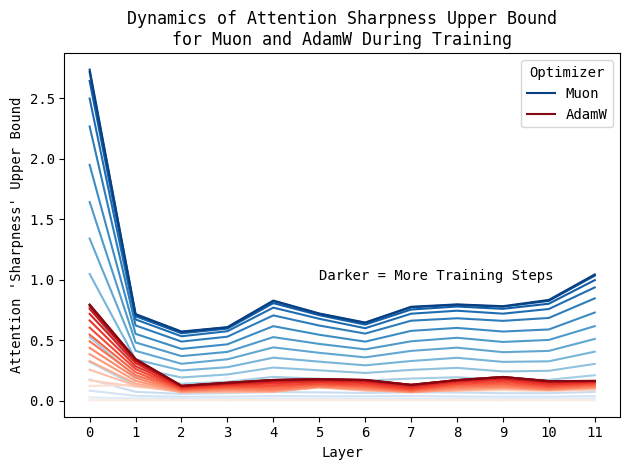

In [ ]:
palette = sns.color_palette("Blues", max_sharpness.shape[1])

for j in range(max_sharpness.shape[1]):
    label = None if j != max_sharpness.shape[1] - 1 else "Muon"
    sns.lineplot(max_sharpness[0][j], color=palette[j], label=label)

palette = sns.color_palette("Reds", max_sharpness.shape[1])

for j in range(max_sharpness.shape[1]):
    label = None if j != max_sharpness.shape[1] - 1 else "AdamW"
    sns.lineplot(max_sharpness[1][j], color=palette[j], label=label)

plt.text(5, 1, "Darker = More Training Steps")

plt.xticks(np.linspace(0, 11, 12))
plt.xlabel("Layer")
plt.ylabel("Attention 'Sharpness' Upper Bound")
plt.title("Dynamics of Attention Sharpness Upper Bound\nfor Muon and AdamW During Training")
# text on legend
plt.legend(title="Optimizer")
plt.tight_layout()
plt.savefig(f"{IMAGES_SAVE_PATH}/attention_sharpness_dynamics.png")

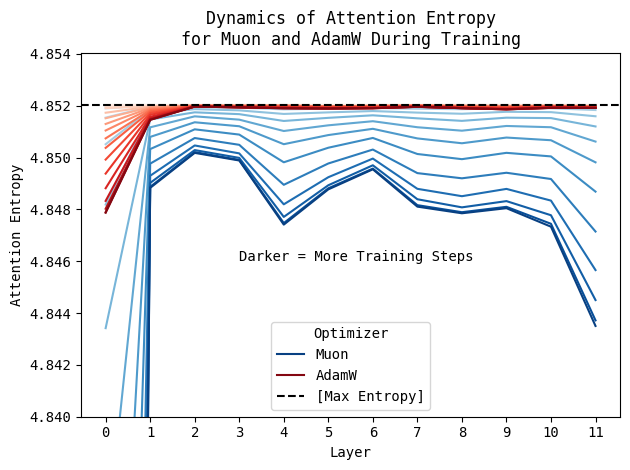

In [ ]:
palette = sns.color_palette("Blues", H_min.shape[1])

for j in range(H_min.shape[1]):
    label = None if j != H_min.shape[1] - 1 else "Muon"
    sns.lineplot(H_min[0][j], color=palette[j], label=label)

palette = sns.color_palette("Reds", H_min.shape[1])

for j in range(H_min.shape[1]):
    label = None if j != H_min.shape[1] - 1 else "AdamW"
    sns.lineplot(H_min[1][j], color=palette[j], label=label)

plt.text(3, 4.846, "Darker = More Training Steps")
plt.axhline(H_max, color="black", linestyle="--", label="[Max Entropy]")

plt.ylim(4.84, H_max + 0.002)
plt.xticks(np.linspace(0, 11, 12))
plt.xlabel("Layer")
plt.ylabel("Attention Entropy")
plt.title("Dynamics of Attention Entropy\nfor Muon and AdamW During Training")
plt.legend(title="Optimizer")
plt.tight_layout()
plt.savefig(f"{IMAGES_SAVE_PATH}/attention_entropy_dynamics.png")